<a href="https://colab.research.google.com/github/Arghaweeb/Self-Drving-Car/blob/main/Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [82]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
np.random.seed(0)
import pickle
import pandas as pd
import random


Unpickling the Files Cloned

In [84]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [85]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [86]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"



In [87]:
data = pd.read_csv('german-traffic-signs/signnames.csv')


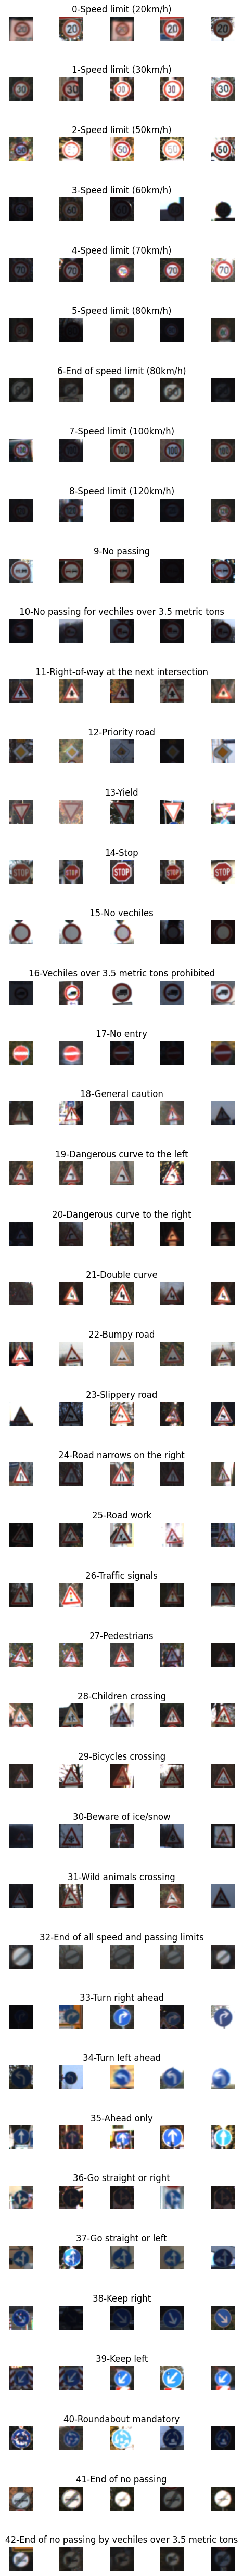

In [89]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():    #(index, series)
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

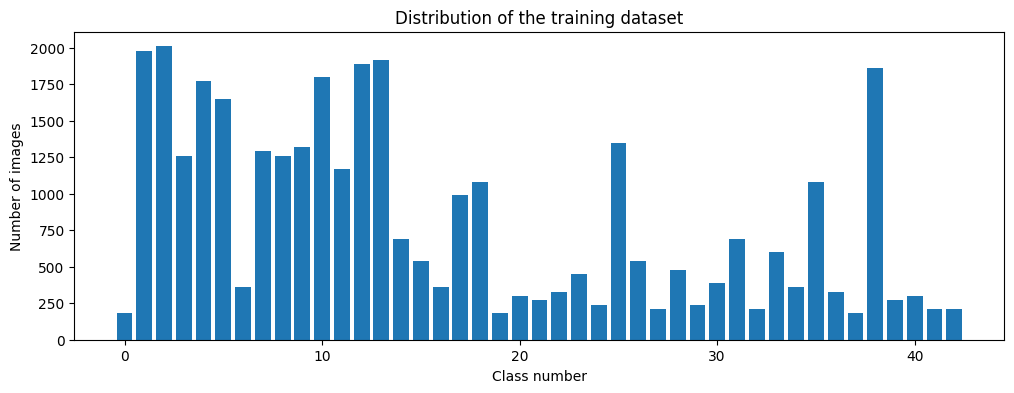

In [90]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

**Preproccessing**

(32, 32, 3)
36


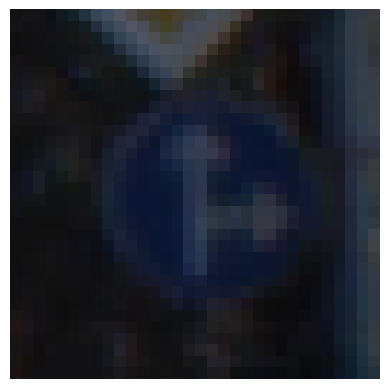

In [91]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [92]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img


(32, 32)


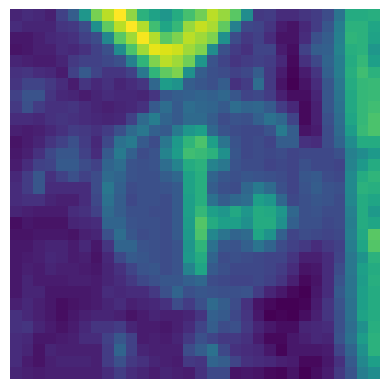

In [93]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

Histogram Equalization : Normalize the Lightning in Image

(32, 32)


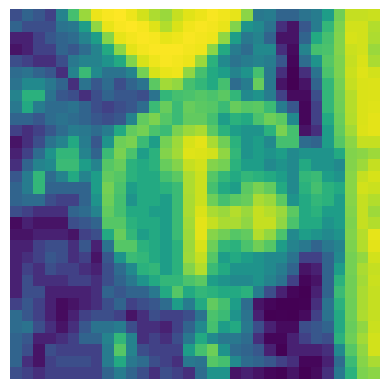

In [94]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [95]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255  #Normalize
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


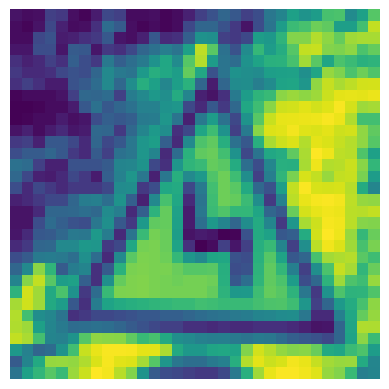

In [96]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [97]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [98]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1, #10% of image width
                   height_shift_range = 0.1,
                   zoom_range = 0.2, # zoom out 0.8
                   shear_range = 0.1, #
                   rotation_range = 10)

datagen.fit(X_train)

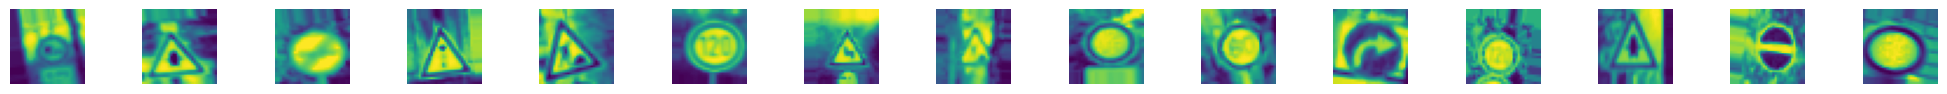

In [99]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')


In [100]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [144]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation = 'relu'))
  model.add(Conv2D(60, (5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation = 'relu')) # 15 * 30 * (9 parameters per filter(3x3) + 15 = 4065 parameters)
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())  #6*6*15
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model



In [145]:
model = modified_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 12, 12, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 4, 4, 30)          0         
 ng2D)                                                

In [146]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch = 600, epochs = 10, validation_data = (X_val, y_val), shuffle=1)

Epoch 1/10
600/600 [==============================] - 17s 25ms/step - loss: 1.7995 - accuracy: 0.4872 - val_loss: 0.3782 - val_accuracy: 0.8853
Epoch 2/10
600/600 [==============================] - 15s 25ms/step - loss: 0.6596 - accuracy: 0.7954 - val_loss: 0.1916 - val_accuracy: 0.9429
Epoch 3/10
600/600 [==============================] - 15s 25ms/step - loss: 0.3950 - accuracy: 0.8749 - val_loss: 0.1098 - val_accuracy: 0.9653
Epoch 4/10
600/600 [==============================] - 15s 24ms/step - loss: 0.2967 - accuracy: 0.9092 - val_loss: 0.0703 - val_accuracy: 0.9814
Epoch 5/10
600/600 [==============================] - 14s 24ms/step - loss: 0.2190 - accuracy: 0.9329 - val_loss: 0.0958 - val_accuracy: 0.9735
Epoch 6/10
600/600 [==============================] - 15s 24ms/step - loss: 0.1958 - accuracy: 0.9387 - val_loss: 0.0711 - val_accuracy: 0.9787
Epoch 7/10
600/600 [==============================] - 15s 24ms/step - loss: 0.1836 - accuracy: 0.9426 - val_loss: 0.0594 - val_accuracy:

Text(0.5, 0, 'epoch')

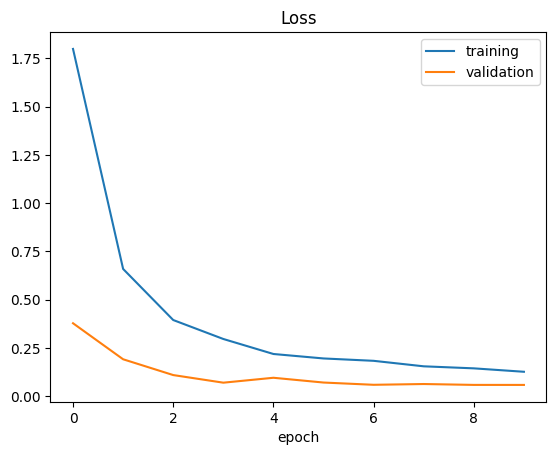

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

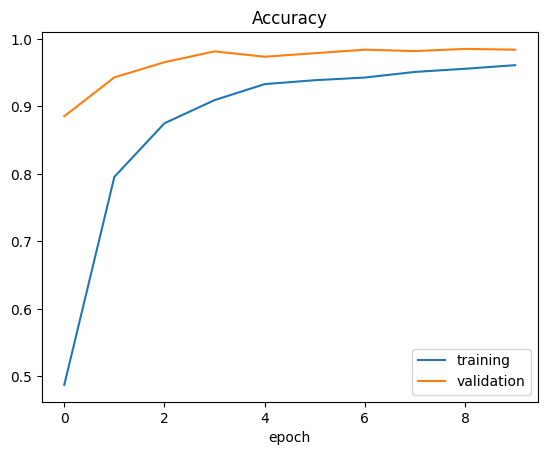

In [148]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [149]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.1338500827550888
Test Accuracy: 0.9635787606239319


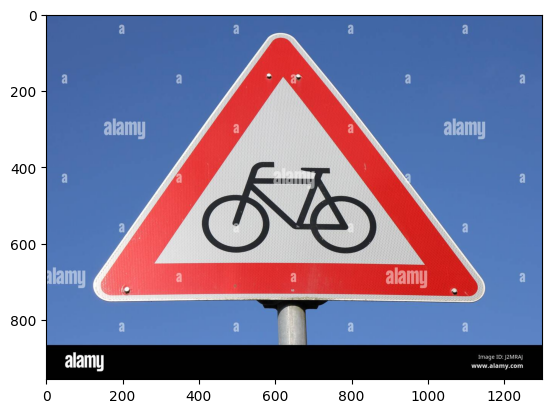

In [150]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'


r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


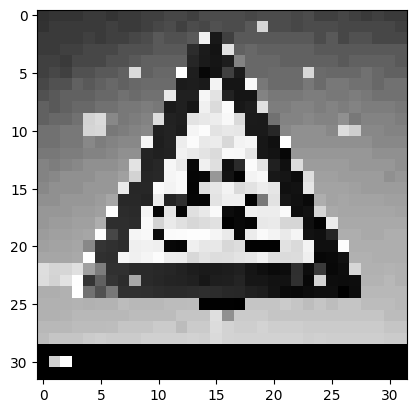

In [151]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [154]:
img = img.reshape(1, 32, 32, 1)

In [155]:
#Test image
pred_prob = model.predict(img)
pred_classes = np.argmax(pred_prob, axis=-1)
print("Predicted sign:" + str(pred_classes))

1/1 [==============================] - 0s 17ms/step
Predicted sign:[29]


Data Augmentation : Generator